In [1]:
# Load in the python script containing the same code as the load the data notebook
%run loadData.py
# now we can access train, dev, and test
# along with trainSents, devSents testSents

In [2]:
# Imports

import pprint
pp = pprint.PrettyPrinter(indent=4)

import nltk
from nltk.corpus import stopwords

from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

from string import punctuation  

import re
import pickle
import os

import csv

from collections import defaultdict


In [3]:
# Core functions

classifier = './stanford/classifiers/english.all.3class.distsim.crf.ser.gz'
jar = './stanford/stanford-ner.jar'

sTagger = StanfordNERTagger(classifier,jar)

punct_tokens = set(punctuation)
extra_tokens = set(["what", "where", "how", "when", "who"])

stop_words = set(stopwords.words('english'))

filter_tokens = extra_tokens.union(punct_tokens).union(stop_words)

In [22]:
train_answers = []
for i in range(0, len(train)):
    qs = train[i]
    for j in range(0, len(qs)):
        q = qs[j]
        answer = q["answer"]
        train_answers.append(answer)

In [23]:
# Shim function for later clean

def getStanfordTagging(datasetName):
    fnameTrain = './preCompTags/stanfordTaggedTrain.txt'
    fnameDev = './preCompTags/stanfordTaggedDev.txt'
    fnameTest = './preCompTags/stanfordTaggedTest.txt'
    
    theFilePath = ''
    theSents = []
    if (datasetName == 'train'):
        theFilePath = fnameTrain
        theSents = trainSents
    elif (datasetName == 'dev'):
        theFilePath = fnameDev
        theSents = devSents
    elif (datasetName == 'test'):
        theFilePath = fnameTest
        theSents = testSents
    elif (datasetName == 'ans_train'):
        theFilePath = './preCompTags/stanfordTaggedTrainAnswers.txt'
        theSents = train_answers
    else :
        raise ValueError('Incorrect datasetName: ' + datasetName + ', choose from - "train", "dev", "test" ') 
    if (os.path.exists(theFilePath)):
        with open(theFilePath, "rb") as fp:
            stanfordTags = pickle.load(fp)
            return stanfordTags
    
    else :
        #Need to create taggings!
        taggedSentsList = []
        for sents in theSents:
            tokenisedSents = [word_tokenize(sent) for sent in sents]
            classifiedSents = sTagger.tag_sents(tokenisedSents)
            taggedSentsList.append(classifiedSents)
        #And save them
        with open(theFilePath, "wb") as fp: 
            pickle.dump(taggedSentsList, fp)
        return taggedSentsList

In [5]:
tagged_train_set = getStanfordTagging('train')
tagged_dev_set = getStanfordTagging('dev')
tagged_test_set = getStanfordTagging('test')

In [8]:
# Shim function for later clean

# Thanks for this list to save me typing it : http://stackoverflow.com/questions/493174/is-there-a-way-to-convert-number-words-to-integers\n",
numInWords = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
        "sixteen", "seventeen", "eighteen", "nineteen", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"
       , "hundred", "thousand", "million", "billion", "trillion"]

punctuation = ["''",'``','(','.',':', ',',')']


months = ["January","February","March","April","May","June","July","August","September","October","November","December"]

def isPunctuation(word):
    return word in punctuation

def isCapitalised (word):
    if len(word) == 0:
        return False
    return word[0].isupper()

# Obtained from training data
postUnits = [u'%', u'century', u'years', u'percent', u'years ago', u'days', u'months', u'km', u'hours', u'times', u'inches', u'\xb0C', u'minutes', u'acres', u'\xb0F', u'weeks', u'people', u'sq mi', u'mi', u'ft', u'feet', u'metres', u'mm', u'square miles', u'miles', u'pm', u'per cent', u'year', u'copies', u'yuan', u'men', u'square feet', u'third', u'kilometres', u'nm', u'tonnes', u'species', u'decades', u'barrels', u'tons', u'largest', u'centuries', u'km2']
preUnits = [u'$',u'around', u'late', u'early', u'nearly', u'since', u'approximately', u'number']

# Returns true if the word represents a number\n",
def isNumber(word):
    pattern = ".?(\\d)+((,|.)(\\d)+)*"
    if re.match(pattern,word) :
        return True
    if word.lower() in numInWords:
        return True
    if word in months:
        return True
    return False

def isStopWord(word):
    return word.lower() in stop_words

In [9]:
grammar = """ ANS: {<JJ>?<N.*>*}
                   {<DT>?<N.*>*}
                   }<UH|POS|VB|VBG|RP|DT|MD|PRP$|TO|RB|JJS|PDT|IN|PRP|VBP|VBN|RBS|WRB|WP|EX|VBZ|WDT|VBD>{
                    """
cp = nltk.RegexpParser(grammar) 

def chunk(words):
    tokenWS = nltk.pos_tag(nltk.word_tokenize(words))
    chunks =  cp.parse(tokenWS)
    possAnswers = []
    for subtree in chunks.subtrees():
        if subtree.label() == 'ANS':
            possAnswers.append((' '.join(word for word, pos in subtree.leaves()),'O'))
    possAnswers.append(("Nope", "CRAP")) # To ensure nothing has 0 tags
    return possAnswers    

In [10]:
def add_non_chunked_words_as_single_tags(words):
    chunked_output = chunk(words)
    token_words = nltk.pos_tag(nltk.word_tokenize(words))
    if len(chunked_output) == 0:
        chunked_words = ["DEREKWANG"]
    else:
        chunked_words = [nltk.word_tokenize(word_tag_pair[0]) for word_tag_pair in chunked_output ]    
    all_word_tags = []
    
    current_chunk_index = 0
    current_chunk_word = 0
    current_chunk_list = chunked_words[0]
    
    for word_tag_pair in token_words:
        word = word_tag_pair[0]
        if word == current_chunk_list[current_chunk_word]:
            # Need to move onto next word
            if current_chunk_word == len(current_chunk_list) - 1:
                # last word in this current chunk
                all_word_tags.append(chunked_output[current_chunk_index])
                current_chunk_index += 1
                current_chunk_word = 0
                if current_chunk_index == len(chunked_words):
                    current_chunk_list = ["NOPE"]
                else:
                    current_chunk_list = chunked_words[current_chunk_index]
            else :
                current_chunk_word += 1
        else :
            # Need to add word, as it's not in a chunk :(
            all_word_tags.append((word,'O'))
    return all_word_tags


In [18]:
# Shim function for later clean

def refine_word_tags(taggedWordList):
    newWordTags = []
    for (word, tag) in taggedWordList:
        if (tag == 'ORGANIZATION'):
            tag = 'O'
        if (tag == 'O'):
            #Might be a number
            if isNumber(word):
                tag = 'NUMBER'
            elif word in preUnits:
                tag = 'PRENUM'
            elif word in postUnits:
                tag = 'POSTNUM'
            elif isCapitalised(word):
                tag = "OTHERCAP"
        newWordTags.append((word, tag))
    
    newWordTags = combineTags (newWordTags)
    other_processed_tags = process_others(newWordTags)
    return other_processed_tags
        
def combineTags(wordTags):
    
    newTags = []
    prevWord = wordTags[0][0]
    prevTag = wordTags[0][1]
    
    for (word, tag) in wordTags[1:]:
        if tag == 'NUMBER' and prevTag == 'PRENUM':
            prevTag = 'NUMBER'
        elif prevTag == 'PRENUM':
            prevTag = 'O'
        if tag == 'POSTNUM' and prevTag == "NUMBER":
            tag = "NUMBER"
        elif tag == "POSTNUM":
            tag = "O"
        newTags.append((prevWord, prevTag))
        prevWord = word
        prevTag = tag
    newTags.append((prevWord, prevTag))
        
    newNewTags = []
    prevWord = newTags[0][0]
    prevTag = newTags[0][1]
    if (prevTag == "OTHERCAP" and newTags[1][1] != "OTHERCAP"):
        prevTag = "O"
        
    for (word, tag) in newTags[1:]:
#         print tag, prevTag
        if tag == prevTag :
            if word == '%':
                prevWord += word
            else :
                if prevWord == '$':
                    prevWord += word
                else :
                    prevWord += ' ' + word
        else :
            newNewTags.append((prevWord, prevTag))
            prevWord = word
            prevTag = tag
            
    newNewTags.append((prevWord, prevTag))
    
    return newNewTags

def process_others(words_with_tags):
    new_taggings = []
    for (words, tag) in words_with_tags:
        if tag == 'O':
            #chunk_results = add_non_chunked_words_as_single_tags(words)
            #for (word,tag) in chunk_results:
            #    new_taggings.append((word, tag))
            new_taggings.append((words,tag))
        else :
            new_taggings.append((words, tag))
    return new_taggings
        

In [19]:
def evaluateNERonDev():
    correct = []
    wrong = []
    
    for i in range(0, len(dev)):
        qs = dev[i]
        for j in range(0, len(qs)):
            q = qs[j]
            idSent  = q["answer_sentence"]
            sent = devSents[i][idSent]
            answer = q["answer"]
            possAnswers = refine_word_tags(tagged_dev_set[i][idSent])
            inThere = False
            for possAnswer in possAnswers:
                if possAnswer[0] == answer:
                    inThere = True
                    break
            if inThere:
                correct.append((i, j, idSent, possAnswers))
            else :
                wrong.append((i, j, idSent, possAnswers))
    return (correct, wrong)


(correct,wrong) = evaluateNERonDev()

In [20]:
print (len(correct) + 0.0)/ (len(correct) + len(wrong))


0.376344086022


In [ ]:
# with others together, and spliting out other cap - 0.376344086022
# 

## Get answers with tags

In [25]:
from collections import defaultdict
def getAnswerDict(qss):
    sentDicts = defaultdict(list)
    for docID in range(0, len(qss)):
        qs = qss[docID]
        for q in qs:
            answer = q["answer"]
            answerSent = (docID, q["answer_sentence"])
            sentDicts[answerSent].append(answer)
    return sentDicts
train_sentence_contained_answers = getAnswerDict(train)


In [26]:
train_sentence_contained_answers[(0,2)] # contains the answers in that sentence

[u'long playing', u'12", 10", 7"', u'rpm']

In [27]:
def getAnswerIndex(sent, answer):
    tokenised_answer = nltk.word_tokenize(answer)
    len_tokenised_answer = len(tokenised_answer)
    tokenised_sent =  nltk.word_tokenize(sent)
    highest_index = (len(tokenised_sent) - len_tokenised_answer) + 1
    
    for i in range (0, highest_index):
            sentence_fragment = tokenised_sent[i:i+len_tokenised_answer]
            if (sentence_fragment == tokenised_answer):
                return (i, i+len_tokenised_answer)
    #print "Problem, cannot find answer index"
    #print sent
    #print answer
    #print
    return (-1,-1)


In [28]:
the_sentence = trainSents[0][0]
the_answers_contained = train_sentence_contained_answers[(0,0)]

print the_sentence
print
print the_answers_contained
print
print getAnswerIndex (the_sentence, the_answers_contained[0])

A gramophone record (phonograph record in American English) or vinyl record, commonly known as a "record", is an analogue sound storage medium in the form of a flat polyvinyl chloride (previously shellac) disc with an inscribed, modulated spiral groove.

[u'analogue sound storage medium']

(24, 28)


In [29]:
def convert_candidates_to_range(candidates):
    candidatesIndexRange = []
    index = 0
    for (words, tag) in candidates:
        tokenisedWords = nltk.word_tokenize(words)
        nextIndex = index + len(tokenisedWords)
        candidatesIndexRange.append((index,nextIndex ))
        index = nextIndex
    return candidatesIndexRange

In [30]:
example_candidates = refine_word_tags(tagged_train_set[0][0])

convert_candidates_to_range(example_candidates)[0:5]

[(0, 7), (7, 9), (9, 49)]

In [31]:
# Get the taggings of the (possibly overlapping) candidates list

def get_taggings_in_range((ans_start,ans_end),candidates):
    candidate_ranges = convert_candidates_to_range(candidates)
    
    current_considered_candidate_id = -1
    candidates_containing_answer = []
    
    for (cand_start, cand_end) in candidate_ranges:
        current_considered_candidate_id += 1
        if ans_start == cand_start and ans_end == cand_end :
            #candidates and answer the same
            candidates_containing_answer.append(current_considered_candidate_id)
            break
        if cand_start <= ans_start and cand_end >= ans_end :
            #candidate contains the answer, but has extra words
            candidates_containing_answer.append(current_considered_candidate_id)
            break

        if cand_start >= ans_start or cand_end > ans_start:
            if (cand_end <= ans_end):
                candidates_containing_answer.append(current_considered_candidate_id)
            else :
                # we have finished, as 
                if (cand_start < ans_end ):
                    candidates_containing_answer.append(current_considered_candidate_id)
                break
    return candidates_containing_answer
    

In [32]:
example_candidates = refine_word_tags(tagged_train_set[0][1])
example_answer_range = (3,6)
print example_candidates
print
print get_taggings_in_range(example_answer_range,example_candidates)

[(u'The groove usually starts near the periphery and ends near the center of the disc .', 'O')]

[0]


In [46]:
def get_NER_tag_analysis() :
    other_taggings = []
    for i in range(0, len(trainSents)):
        sent_set = trainSents[i]
        for j in range(0, len(sent_set)):
            sent = sent_set[j]
            answers_in_sent = train_sentence_contained_answers[(i,j)]
            candidates = refine_word_tags(tagged_train_set[i][j])
            for answer in answers_in_sent:
                (ans_start, ans_end) = getAnswerIndex(sent, answer)
                if (ans_start, ans_end) == (-1,-1) :
                    continue
                   
                candidate_ids = get_taggings_in_range((ans_start, ans_end),candidates)
                if len(candidate_ids) == 1:
                    possible_correct_candidate = candidates[candidate_ids[0]]
                    if possible_correct_candidate[1] == "O":
                        other_taggings.append(answer)
    return other_taggings

In [47]:
# Ie answers that were tagged as otherh
aswers_tagged_as_other = get_NER_tag_analysis()

Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - should be not many
Correct - shou

## Generate rules for Parser

In [51]:
# Lets generate our data!
# For each answer - tag it, and if other:
# add to list

from collections import Counter
other_pos_tag_counter = Counter()

for ans in aswers_tagged_as_other:
    tokenised_answer = nltk.word_tokenize(ans)
    pos_answer =  nltk.pos_tag(tokenised_answer)
    
    just_tags = [pair[1] for pair in pos_answer]
    other_pos_tag_counter[tuple(just_tags)] += 1
        

In [53]:
other_pos_tag_counter.most_common(5)

[(('NN',), 4568),
 (('NNS',), 1510),
 (('JJ', 'NN'), 1325),
 (('JJ',), 1196),
 (('NN', 'NN'), 954)]

In [58]:
tags_by_answer_length = []

for i in range(0, 10):
    tags_by_answer_length.append(Counter())
    
for tag_tuple in other_pos_tag_counter.keys():
    answer_length = len(tag_tuple)
    if answer_length == 0:
        continue
    answer_index = answer_length - 1
    if answer_index >= 10:
        continue
    tags_by_answer_length[answer_index][tag_tuple] += other_pos_tag_counter[tag_tuple]

In [59]:
tags_by_answer_length[0].most_common(5)

[(('NN',), 4568),
 (('NNS',), 1510),
 (('JJ',), 1196),
 (('CD',), 233),
 (('VBG',), 194)]

In [60]:
tags_by_answer_length[1].most_common(5)

[(('JJ', 'NN'), 1325),
 (('NN', 'NN'), 954),
 (('JJ', 'NNS'), 847),
 (('NN', 'NNS'), 620),
 (('DT', 'NN'), 448)]

In [138]:
from collections import defaultdict
tag_terminal_names = defaultdict(lambda:"TERM0")

    
all_tag_types = set()
for tags in other_pos_tag_counter:
    for tag in tags:
        all_tag_types.add(tag)
     

next_terminal_id = 0
for tag in all_tag_types:
    tag_terminal_name = tag
    if not tag.isalpha():
        tag_terminal_name = "TERM" + str(next_terminal_id)
        next_termindal_id += 1
    tag_terminal_names[tag] = tag_terminal_name

In [140]:
print tag_terminal_names["$"]
print tag_terminal_names["NN"]
print tag_terminal_names['joshi'] # an unseen pos tag appears

TERM0
NN
TERM0


In [206]:
def give_grammar_rules(tags,prob):
    grammar_rules = set()
    
    if len(tags)== 1:
        first_tag = tags[0]
        first_tag_terminal = tag_terminal_names[first_tag]
        grammar_rules.add("SIZE_ONE -> " + first_tag_terminal + " [" + str(prob) + "]")
        new_rules = get_sub_grammar_rules(tags)
        grammar_rules = grammar_rules.union(new_rules)
    if len(tags) == 2:
        grammar_rules.add("SIZE_TWO -> " + tag_terminal_names[tags[0]] + " " + tag_terminal_names[tags[1]] +
                           " [" + str(prob) + "]")        
        grammar_rules = grammar_rules.union(get_sub_grammar_rules(tags))
    if len(tags) == 3:
        grammar_rules.add("SIZE_THREE -> " + tag_terminal_names[tags[0]] + '_' + tag_terminal_names[tags[1]] + " " +tag_terminal_names[tags[2]] +  " [" + str(prob) + "]")
        grammar_rules = grammar_rules.union(get_sub_grammar_rules(tags))
    return grammar_rules
        
def get_sub_grammar_rules(tags):
    grammar_rules = set()
    if len(tags) == 1:
        first_tag = tags[0]

        first_tag_terminal = tag_terminal_names[first_tag]
        grammar_rules.add(first_tag_terminal + ' -> ' + '"' + first_tag + '"' + " [1]")

    if len(tags) == 2:
        grammar_rules.add(tag_terminal_names[tags[0]] + ' -> ' + '"' + tags[0] + '"' + " [1]")
        grammar_rules.add(tag_terminal_names[tags[1]] + ' -> ' + '"' + tags[1] + '"' + " [1]")
        
    if len(tags) == 3:
        grammar_rules = grammar_rules.union(get_sub_grammar_rules([tags[2]]))
        grammar_rules.add(tag_terminal_names[tags[0]] + '_'+tag_terminal_names[tags[1]]+ " -> " + tag_terminal_names[tags[0]] + ' ' +  tag_terminal_names[tags[1]] + " [1]")
        grammar_rules = grammar_rules.union(get_sub_grammar_rules([tags[0]]))
        grammar_rules = grammar_rules.union(get_sub_grammar_rules([tags[1]]))
    return grammar_rules

In [208]:
#print give_grammar_rules(('NNP',),0.5)
#print give_grammar_rules(('NNP',"NN"), 0.2)
print give_grammar_rules(('NNP','NN',"NNP"),0.5)

set(['NNP -> "NNP" [1]', 'SIZE_THREE -> NNP_NN NNP [0.5]', 'NN -> "NN" [1]', 'NNP_NN -> NNP NN [1]'])


In [247]:
total_sizes = [0,0,0,0,0]
for i in range(0, 3):
      total_sizes[i]= sum (tags_by_answer_length[i].values())

total_ans = sum(total_sizes)
grammar_rules = set()
for ans_length in range(0, 3):
    if ans_length == 0 :      
        for (tag, val) in tags_by_answer_length[0].most_common(1000000): # Ie all
            prob_of_tag = (val + 0.0) / total_sizes[ans_length]
            grammar_rules = grammar_rules.union( give_grammar_rules(tag,prob_of_tag))
    else :   
        for (tags, val) in tags_by_answer_length[ans_length].most_common(5):
            prob_of_tag = (val + 0.0) / total_sizes[ans_length]
            grammar_rules = grammar_rules.union(give_grammar_rules(tags,prob_of_tag))
    
    

In [283]:
grammar_rules.add("WORDS -> WORD WORDS [0.5]")
grammar_rules.add("WORDS -> WORD [0.5]")

grammar_rules.add("WORD -> SIZE_ONE [0.01]")
grammar_rules.add("WORD -> SIZE_TWO [0.1]")
grammar_rules.add("WORD -> SIZE_THREE [0.89]")


In [284]:
# Okay, so the above gives some rules to start!
rules_in_string = ""
for rule in grammar_rules:
    rules_in_string += rule + '\n'

In [285]:
print rules_in_string[0:100]

S -> SIZE_THREE [0.89]
SIZE_ONE -> VB [0.000971109492595]
SIZE_TWO -> JJ NN [0.239515545915]
WORD ->


In [286]:
from nltk.grammar import ProbabilisticProduction, PCFG, Nonterminal
PCFG.EPSILON = 1000000
answer_pcfg = PCFG.fromstring(rules_in_string)

In [287]:
answer_pcfg.is_flexible_chomsky_normal_form()

True

In [288]:
def parse_CYK(words, grammar):
    table = defaultdict(dict)    
    back = defaultdict(dict)
    
    # righter-most index j
    for j in range(1, len(words)+1):
        # insert token preterminal rewrites, POS -> 'word'
        token = words[j-1]
        for prod in grammar.productions(rhs=token):
            if len(prod.rhs()) == 1:
                table[j-1,j][prod.lhs()] = prod.prob()

        # deal with pesky unary productions 
        changes = True
        cell = table[j-1,j]
        while changes:
            # repeat this loop until no rule changes; will infinitely
            # loop for grammars with a unary cycle
            changes = False
            for non_term in list(cell.keys()):
                prob = cell[non_term]
                for prod in grammar.productions(rhs=non_term):
                    if len(prod.rhs()) == 1:
                        unary_prob = prod.prob() * prob
                        if unary_prob > cell.get(prod.lhs(), 0):
                            cell[prod.lhs()] = unary_prob
                            back[j-1,j][prod.lhs()] = (None, prod)
                            changes = True
        
        # now look for larger productions that span [i, j]
        # allowing i to move leftward over the input
        for i in range(j-2, -1, -1):
            cell = table[i,j]
            # k is the split point, i < k < j
            for k in range(i+1, j):
                # find chart cells based on the split point
                left_cell = table[i,k]
                right_cell = table[k,j]
                # find binary productions which handle a valid symbol A from left cell, X -> A B
                for left_nt, left_prob in left_cell.items():
                    for prod in grammar.productions(rhs=left_nt):
                        if len(prod.rhs()) == 2:
                            # check if the left and right cells have a valid parse
                            right_prob = right_cell.get(prod.rhs()[1])
                            if left_prob != None and right_prob != None:
                                # score the partial parse
                                prob = prod.prob() * left_prob * right_prob
                                if prob > cell.get(prod.lhs(), 0.0):
                                    # if it exceeds the current best analysis, update the cell
                                    cell[prod.lhs()] = prob
                                    # and store a record of how we got here
                                    back[i,j][prod.lhs()] = (k, prod)
        # display the table and back pointers
    display_CYK_chart(words, table, back)
    
    # have to build the tree from the back pointers
    return build_tree(words, back, grammar.start(), i=0, j=len(words))

In [289]:
from IPython.core.display import display, HTML

In [290]:
def display_CYK_chart(words, table, back):
    length = len(words)
    html = ''
    html += '<tr>'
    for i in range(length):
        html += '<td><i>%s<i></td>' % words[i]
    html += '</tr>'
    for i in range(length):
        html += '<tr>'
        for j in range(1, length+1):
            if j <= i:
                html += '<td>'
            else:
                html += "<td bgcolor='lightcyan'>"
                html += '[%d,%d]' % (i,j) 
                for symbol, prob in table.get((i,j), {}).items():
                    html += '<br><b>%s</b> [%.5f]' % (str(symbol), prob)
                    b = back[i,j].get(symbol)
                    if b != None:
                        html += '<br>&nbsp; (k=%s, %s)' % (b[0], str(b[1]))
            html += '</td>'
        html += '</tr>'
    display(HTML(html))

In [291]:
def build_tree(words, back, symbol, i, j):
    backpointer = back[i, j].get(symbol)
    if backpointer == None:
        # X -> 'word' production
        assert j == i+1
        return nltk.tree.Tree(symbol, [words[i]])
    else:
        k, prod = back[i, j][symbol]
        if k != None:
            # X -> A B binary production
            left_subtree = build_tree(words, back, prod.rhs()[0], i=i, j=k)
            right_subtree = build_tree(words, back, prod.rhs()[1], i=k, j=j)
            return nltk.tree.Tree(symbol, [left_subtree, right_subtree])
        else:
            # X -> A unary production
            subtree = build_tree(words, back, prod.rhs()[0], i=i, j=j)
            return nltk.tree.Tree(symbol, [subtree])

NN
"[0,1]S [0.00555] (k=None, S -> SIZE_ONE [0.01])WORDS [0.00277] (k=None, WORDS -> WORD [0.5])WORD [0.00555] (k=None, WORD -> SIZE_ONE [0.01])SIZE_ONE [0.55450] (k=None, SIZE_ONE -> NN [0.554504])NN [1.00000]"


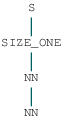

In [292]:
parse_CYK('NN'.split(), answer_pcfg)

In [293]:
parse_CYK(['NN','NN'], answer_pcfg)

NN,NN
"[0,1]S [0.00555] (k=None, S -> SIZE_ONE [0.01])WORDS [0.00277] (k=None, WORDS -> WORD [0.5])WORD [0.00555] (k=None, WORD -> SIZE_ONE [0.01])SIZE_ONE [0.55450] (k=None, SIZE_ONE -> NN [0.554504])NN [1.00000]","[0,2]SIZE_TWO [0.17245] (k=1, SIZE_TWO -> NN NN [0.172451])WORDS [0.00001] (k=1, WORDS -> WORD WORDS [0.5])"
,"[1,2]S [0.00555] (k=None, S -> SIZE_ONE [0.01])WORDS [0.00277] (k=None, WORDS -> WORD [0.5])WORD [0.00555] (k=None, WORD -> SIZE_ONE [0.01])SIZE_ONE [0.55450] (k=None, SIZE_ONE -> NN [0.554504])NN [1.00000]"


AssertionError: 

In [242]:
prods = answer_pcfg.productions()
print prods[0]

SIZE_THREE -> NNS_DT NN [0.000643087]


In [246]:
print answer_pcfg.productions(lhs=Nonterminal('SIZE_THREE'), rhs = "NN")

[]
